#### $\text{Data Science Analysis (PH6130): Course Project}$
$\text{Member 1: Koushik Maji, AI23MTECH11004}$  
$\text{Member 2: Rahul Verma,  AI23MTECH11008}$

*Caution : This notebook is compiled using cuda on plase use device with cuda enebled or platform like kaggle and colab to run this or make remove the part where models and data are sent to cuda to complie the code smoothly *

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")

from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
import torch
from torch import nn
from torchvision import datasets, transforms
import torch.utils
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, roc_curve

In [2]:
BATCH_SIZE = 1000
CHANNELS = 1
HEIGHT = 28
WIDTH = 28
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [30]:
# Download the training data
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

# Load the training data
train_loader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True,num_workers=4, persistent_workers=True)

# Download the test data
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

# Load the test data
test_loader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True,num_workers=4, persistent_workers=True)


In [4]:
for images, labels in train_loader:
    print("Shape of images batch:", images.shape)
    print("Shape of labels batch:", labels.shape)
    break  # To only print the first batch


Shape of images batch: torch.Size([1000, 1, 28, 28])
Shape of labels batch: torch.Size([1000])


In [5]:
classes = trainset.classes
classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

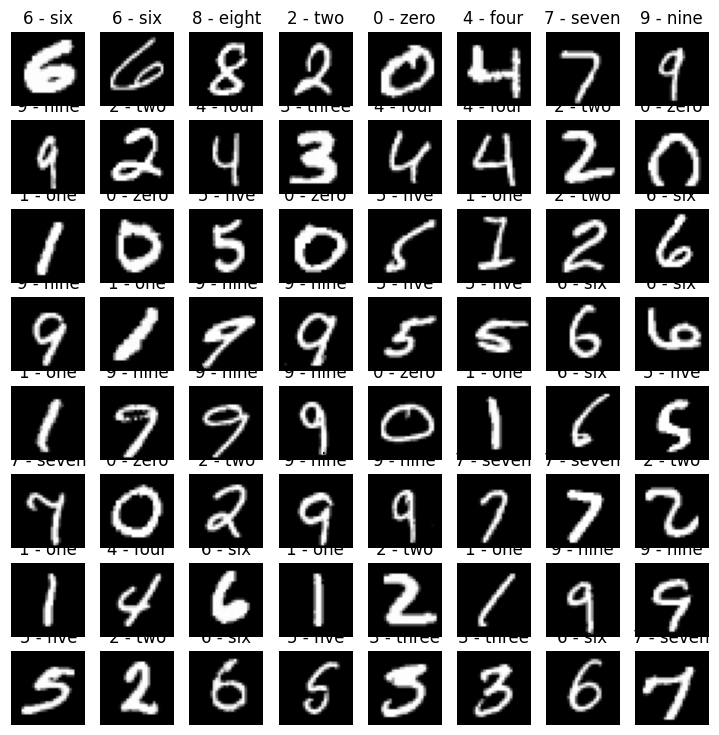

In [6]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows,cols = 8,8

for i in range(1,cols*rows+1):
    random_idx = torch.randint(0,len(trainset),size=[1]).item()
    img,label = trainset[random_idx]
    fig.add_subplot(rows,cols,i)
    plt.imshow(img.squeeze(),cmap='gray')
    plt.title(classes[label])
    plt.axis(False);

Variational Autoencoder (VAE)

In [7]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=3)
if torch.cuda.is_available():
    vae.cuda()

In [9]:
import torch.optim as optim
optimizer = optim.Adam(vae.parameters(),lr = 0.001)
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [10]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [11]:
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.cuda()
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [12]:
for epoch in range(1, 51):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 543.195062
====> Epoch: 1 Average loss: 241.4581
====> Test set loss: 199.3853
Train Epoch: 2 [0/60000 (0%)]	Loss: 199.290781
====> Epoch: 2 Average loss: 189.2891
====> Test set loss: 177.9899
Train Epoch: 3 [0/60000 (0%)]	Loss: 177.804812
====> Epoch: 3 Average loss: 173.1708
====> Test set loss: 166.1175
Train Epoch: 4 [0/60000 (0%)]	Loss: 166.257422
====> Epoch: 4 Average loss: 162.2161
====> Test set loss: 158.0673
Train Epoch: 5 [0/60000 (0%)]	Loss: 161.366281
====> Epoch: 5 Average loss: 155.7958
====> Test set loss: 153.2405
Train Epoch: 6 [0/60000 (0%)]	Loss: 154.178500
====> Epoch: 6 Average loss: 151.6725
====> Test set loss: 150.0859
Train Epoch: 7 [0/60000 (0%)]	Loss: 149.212547
====> Epoch: 7 Average loss: 148.8078
====> Test set loss: 148.0560
Train Epoch: 8 [0/60000 (0%)]	Loss: 147.196547
====> Epoch: 8 Average loss: 146.8925
====> Test set loss: 146.2557
Train Epoch: 9 [0/60000 (0%)]	Loss: 145.178141
====> Epoch: 9 Average loss: 145.

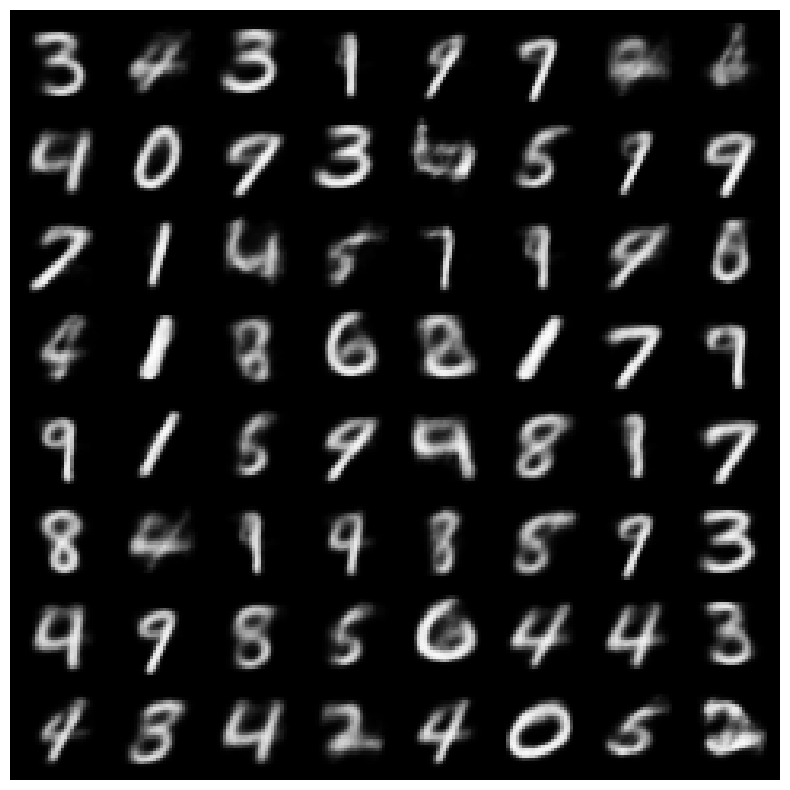

In [14]:
from torchvision.utils import save_image, make_grid

with torch.no_grad():
    z = torch.randn(64, 3).cuda()
    sample = vae.decoder(z).cuda()

    # Save the image
    save_image(sample.view(64, 1, 28, 28), 'sample9.png')

    # Create a grid of images and convert to numpy
    grid = make_grid(sample.view(64, 1, 28, 28)).cpu().numpy()

    # Transpose the grid for displaying
    grid = np.transpose(grid, (1, 2, 0))

    # Plot the grid
    plt.figure(figsize=(10,10))
    plt.imshow(grid)
    plt.axis('off')
    plt.show()


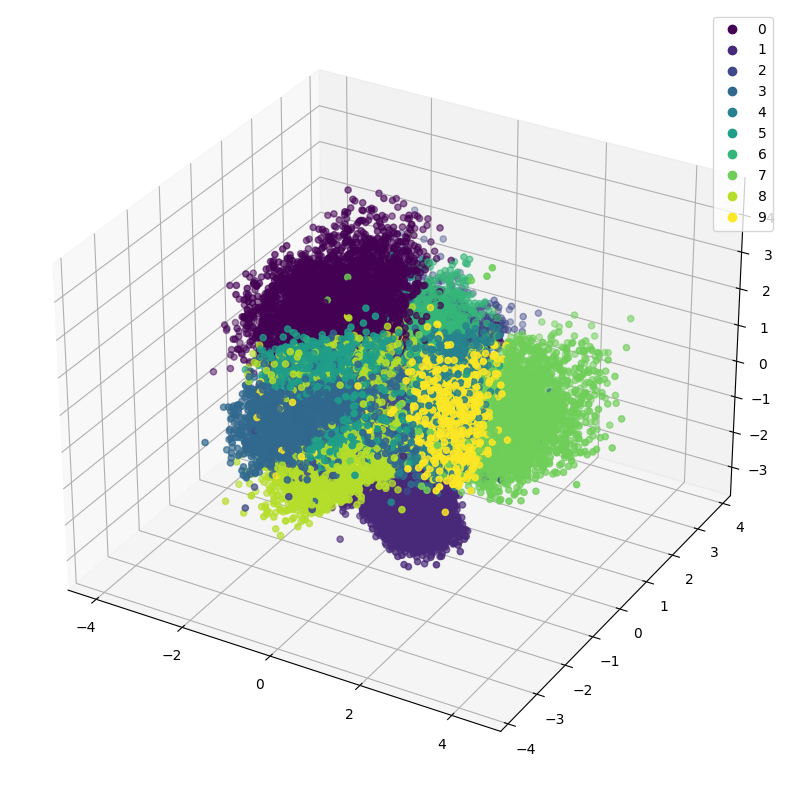

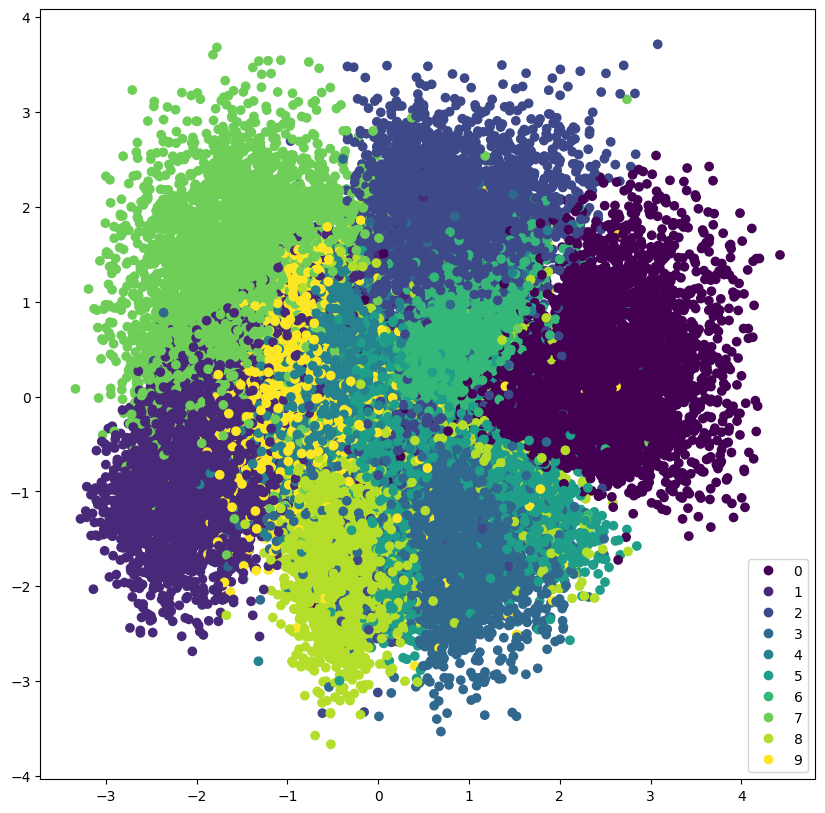

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

# Assuming data_loader is your DataLoader object for the dataset
mu_values = []
labels = []
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.cuda()

        # Pass data through VAE
        recon_batch, mu, log_var = vae(data)

        # Store mu values and labels
        mu_values.append(mu.detach().cpu().numpy())
        labels.append(target.numpy())

# Convert list of arrays into one array
mu_values = np.concatenate(mu_values, axis=0)
labels = np.concatenate(labels, axis=0)

# Create 3D plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(mu_values[:, 0], mu_values[:, 1], mu_values[:, 2], c=labels)
plt.legend(*scatter.legend_elements())
plt.show()

# Perform PCA
pca = PCA(n_components=2)
mu_values_pca = pca.fit_transform(mu_values)

# Create 2D plot
plt.figure(figsize=(10, 10))
scatter = plt.scatter(mu_values_pca[:, 0], mu_values_pca[:, 1], c=labels)
plt.legend(*scatter.legend_elements())
plt.show()


### VAE without_kld bce and central loss

In [58]:
class VAE_mod(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE_mod, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var


class CenterLoss(nn.Module):
    def __init__(self, num_classes, feat_dim, device=torch.device('cpu')):
        super(CenterLoss, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.device = device
        
        self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim).to(self.device))

    def forward(self, x, labels):
        batch_size = x.size(0)
        distmat = torch.pow(x, 2).sum(dim=1, keepdim=True).expand(batch_size, self.num_classes) + \
                   torch.pow(self.centers, 2).sum(dim=1, keepdim=True).expand(self.num_classes, batch_size).t()
        distmat.addmm_(1, -2, x, self.centers.t())

        classes = torch.arange(self.num_classes).long().to(self.device)
        labels = labels.unsqueeze(1).expand(batch_size, self.num_classes)
        mask = labels.eq(classes.expand(batch_size, self.num_classes))

        dist = []
        for i in range(batch_size):
            value = distmat[i][mask[i]]
            value = value.clamp(min=1e-12, max=1e+12) # for numerical stability
            dist.append(value)
        dist = torch.cat(dist)
        loss = dist.mean()

        return loss


# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var, y):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    center_loss = CenterLoss(num_classes=10, feat_dim=mu.size(1), device=mu.device)
    CL = center_loss(mu, y)
    return BCE  + 3*CL

In [59]:
# build model
vae_mod = VAE_mod(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=6)
if torch.cuda.is_available():
    vae_mod.cuda()
    
import torch.optim as optim
optimizer = optim.Adam(vae_mod.parameters(),lr = 0.001)


def train(epoch):
    vae_mod.train()
    train_loss = 0
    for batch_idx, (data, y) in enumerate(train_loader):
        data = data.cuda()
        y = y.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae_mod(data)
        loss = loss_function(recon_batch, data, mu, log_var, y)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))
    
    
def test():
    vae_mod.eval()
    test_loss= 0
    with torch.no_grad():
        for data, y in test_loader:
            data = data.cuda()
            y = y.cuda()
            recon, mu, log_var = vae_mod(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var, y).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    
    
for epoch in range(1, 51):
    train(epoch)
    test()


Train Epoch: 1 [0/60000 (0%)]	Loss: 543.083062
====> Epoch: 1 Average loss: 241.5270
====> Test set loss: 195.2608
Train Epoch: 2 [0/60000 (0%)]	Loss: 194.942359
====> Epoch: 2 Average loss: 185.6795
====> Test set loss: 168.0252
Train Epoch: 3 [0/60000 (0%)]	Loss: 169.628312
====> Epoch: 3 Average loss: 152.3626
====> Test set loss: 137.6696
Train Epoch: 4 [0/60000 (0%)]	Loss: 139.557172
====> Epoch: 4 Average loss: 130.5374
====> Test set loss: 122.0684
Train Epoch: 5 [0/60000 (0%)]	Loss: 123.797438
====> Epoch: 5 Average loss: 119.1334
====> Test set loss: 115.1511
Train Epoch: 6 [0/60000 (0%)]	Loss: 114.509969
====> Epoch: 6 Average loss: 114.1276
====> Test set loss: 111.7459
Train Epoch: 7 [0/60000 (0%)]	Loss: 110.415461
====> Epoch: 7 Average loss: 110.9765
====> Test set loss: 109.1446
Train Epoch: 8 [0/60000 (0%)]	Loss: 110.772266
====> Epoch: 8 Average loss: 108.7098
====> Test set loss: 107.3133
Train Epoch: 9 [0/60000 (0%)]	Loss: 104.891781
====> Epoch: 9 Average loss: 107.

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

# Assuming data_loader is your DataLoader object for the dataset
mu_values = []
labels = []
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.cuda()

        # Pass data through VAE
        recon_batch, mu, log_var = vae_mod(data)

        # Store mu values and labels
        mu_values.append(mu.detach().cpu().numpy())
        labels.append(target.numpy())

# Convert list of arrays into one array
mu_values = np.concatenate(mu_values, axis=0)
labels = np.concatenate(labels, axis=0)


# compile with latent dimension 3 to generate this 3d plot 

# # Create 3D plot
# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111, projection='3d')
# scatter = ax.scatter(mu_values[:, 0], mu_values[:, 1], mu_values[:, 2], c=labels)
# plt.legend(*scatter.legend_elements())

# # Set the DPI for high-resolution output
# plt.savefig('3d_plot.png', dpi=300)  # Adjust the file format and DPI as needed
# plt.show()


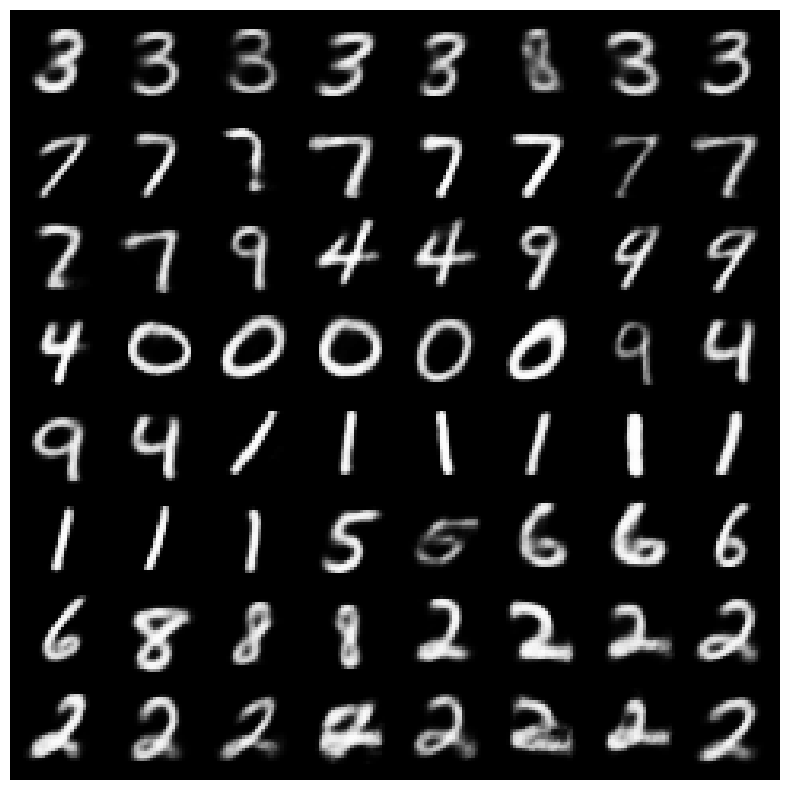

In [84]:
from sklearn.mixture import GaussianMixture

# Fit a GMM with 10 components to the data
gmm = GaussianMixture(n_components=10)
gmm.fit(mu_values)

# Make the variance of each Gaussian half
gmm.covariances_ /= 1.5

# Sample from the GMM
samples, _ = gmm.sample(64)

from torchvision.utils import save_image, make_grid

# Convert GMM samples to tensor and send to GPU
z = torch.from_numpy(samples).float().cuda()

with torch.no_grad():
    # Pass the samples through the decoder
    sample = vae_mod.decoder(z)

    # Save the image
    save_image(sample.view(64, 1, 28, 28), 'sample_gmm.png')

    # Create a grid of images and convert to numpy
    grid = make_grid(sample.view(64, 1, 28, 28)).cpu().numpy()

    # Transpose the grid for displaying
    grid = np.transpose(grid, (1, 2, 0))

    # Plot the grid
    plt.figure(figsize=(10,10))
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

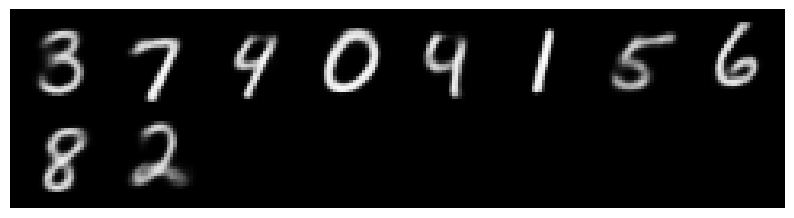

In [85]:
# Get the means of the GMM components
gmm_means = gmm.means_

# Convert GMM means to tensor and send to GPU
z_means = torch.from_numpy(gmm_means).float().cuda()

with torch.no_grad():
    # Pass the means through the decoder
    sample_means = vae_mod.decoder(z_means)

    # Save the image
    save_image(sample_means.view(10, 1, 28, 28), 'sample_gmm_means.png')

    # Create a grid of images and convert to numpy
    grid_means = make_grid(sample_means.view(10, 1, 28, 28)).cpu().numpy()

    # Transpose the grid for displaying
    grid_means = np.transpose(grid_means, (1, 2, 0))

    # Plot the grid
    plt.figure(figsize=(10,10))
    plt.imshow(grid_means)
    plt.axis('off')
    plt.show()